In [ ]:
!pip install transformers tqdm pandas statsmodels datasets scikit-learn flax jax jaxlib linearmodels statsmodels datasets scikit-learn matplotlib vaderSentiment

In [ ]:
# Loading data from hugging face
import datasets
from datasets import load_dataset
import pandas as pd

datasets.logging.set_verbosity_error()
data = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

print(data["full"].column_names)

df = pd.DataFrame(data["full"])

print(df.head())

In [ ]:
# Creating Features
df['review_length'] = df['text'].apply(len)
df['helpful_vote'] = df['helpful_vote'].fillna(0)
df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if x else 0)
df['has_images'] = df['images'].apply(lambda x: 1 if x else 0)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
print(df.head())

In [ ]:
# Meta item data joint with review data
import pandas as pd


df1 = pd.DataFrame()
df2 = pd.DataFrame()

print("Data1 Parent ASINs:", df1['parent_asin'].unique())
print("Data2 Parent ASINs:", df2['parent_asin'].unique())

merged_df = pd.merge(df1, df2, on='parent_asin', how='inner')

if merged_df.empty:
    print("Empty")
else:
    json_lines = merged_df.to_json(orient='records', lines=True)

    save_path = '' 
    with open(save_path, 'w') as file:
        file.write(json_lines)

print(merged_df)

In [ ]:
# Training
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

#	Load the RoBERTa pre-trained model and the corresponding tokenizer.
#	Load the model onto the CUDA device (GPU) for inference, which is why I choose to build the project on CoLAB: My laptop chip was M1 Pro which is not support to CUDA, I can only accelerate training through CPU. So for the concern of time cost, I choosed Colab Pro with CUDA support

model_name = "Proggleb/roberta-base-bne-finetuned-amazon_reviews_multi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda')

# The truncate_text function is used to truncate text that exceeds the maximum length, which will help me decrease GPU memory and RAM usage, speed up the training
def truncate_text(text, max_length=512):
    return text[:max_length]
# The preprocess_and_analyze function tokenizes the text, encodes it, and feeds it into the model to compute sentiment scores.
#	The softmax function is used to compute the probability of each sentiment class, and the difference between the positive and negative sentiment scores is calculated.
def preprocess_and_analyze(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')
    with torch.no_grad():
        logits = model(**inputs).logits
    scores = torch.nn.functional.softmax(logits, dim=-1)
    sentiments = scores[:, 1] - scores[:, 0]  # POSITIVE score - NEGATIVE score
    return sentiments.cpu().numpy()
# The parallel_processing function processes each batch of text data, calls the preprocess_and_analyze function for analysis, and returns the sentiment scores. Same purpose of Truncation, it allows me to mapping function to processing data by 20 units per batch.
def parallel_processing(batch_texts):
    batch_predictions = preprocess_and_analyze(batch_texts)
    return np.array(batch_predictions)

batch_size = 20
all_predictions = []

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for i in range(0, len(df), batch_size):
        batch_texts = df['text'][i:i+batch_size].tolist()
        futures.append(executor.submit(parallel_processing, batch_texts))

    for future in tqdm(futures, desc="Processing batches"):
        all_predictions.extend(future.result())

df['sentiment_score'] = all_predictions
df.to_json('sentiment_analysis_results.jsonl', orient='records', lines=True)
print(df.head())

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

file_path = '/Users/xinliguo/Downloads/sentiment_analysis_results_roberta.jsonl'
data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Transfer to pandas DataFrame
benchmark_df = pd.json_normalize(data)

# Convert Rating into Sentiment Classification
def convert_rating_to_sentiment(rating):
    if rating in [1, 2, 3]:
        return 0  # Negative
    elif rating in [4, 5]:
        return 1  # Positive

benchmark_df['label'] = benchmark_df['rating'].apply(convert_rating_to_sentiment)

# Try different threshold to optimise the model performance
best_threshold = -0.6
best_f1_score = 0.0

for threshold in np.arange(-1.0, 1.0, 0.1):
    predicted_labels = []
    for score in benchmark_df['sentiment_score']:
        if score <= threshold:
            predicted_labels.append(0)  # Negative
        else:
            predicted_labels.append(1)  # Positive

    # True labels from benchmark dataset
    true_labels = benchmark_df['label'].values

    # Evaluate Model Performance
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

# Use the best threshold to evaluate model
predicted_labels = []
for score in benchmark_df['sentiment_score']:
    if score <= best_threshold:
        predicted_labels.append(0)  # Negative
    else:
        predicted_labels.append(1)  # Positive

# Evaluation report
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])

print(f"Best Threshold: {best_threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", report)



# Initialize variables to store thresholds and corresponding F1 scores
thresholds = np.arange(-1.0, 1.0, 0.1)
f1_scores = []

# Calculate the F1 score for each threshold 
for threshold in thresholds:
    predicted_labels = []
    for score in benchmark_df['sentiment_score']:
        if score <= threshold:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    f1 = f1_score(benchmark_df['label'].values, predicted_labels, average='weighted')
    f1_scores.append(f1)

# Plot the relationship between thresholds and F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.show()

# Compute the confusion matrix using the optimal threshold
best_predicted_labels = []
for score in benchmark_df['sentiment_score']:
    if score <= best_threshold:
        best_predicted_labels.append(0)
    else:
        best_predicted_labels.append(1) 

cm = confusion_matrix(benchmark_df['label'].values, best_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plotting confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix ')
plt.show()

# Plotting model performance
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

# Plotting the ROC curve for actual labels and predicted probabilities
true_labels = benchmark_df['label'].values
predicted_scores = benchmark_df['sentiment_score'].values

fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Plotting R0C
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(overall_metrics.keys(), overall_metrics.values())
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Overall Model Performance')
plt.show()

Best Threshold: -0.40000000000000013
Accuracy: 0.7595
Precision: 0.7569
Recall: 0.7595
F1-score: 0.7581

Classification Report:
               precision    recall  f1-score   support

    Negative       0.58      0.56      0.57    201421
    Positive       0.83      0.84      0.83    500107

    accuracy                           0.76    701528
   macro avg       0.71      0.70      0.70    701528
weighted avg       0.76      0.76      0.76    701528



KeyError: 'sentiment_score'

In [4]:
# Processing 1100 Reviews data
import json
from collections import defaultdict

input_file = '/Users/xinliguo/Downloads/merged_roberta.jsonl'
output_file_jsonl = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'
output_file_json = '/Users/xinliguo/Downloads/filtered_reviews1100.json'

with open(input_file, 'r') as file:
    lines = file.readlines()

review_counts = defaultdict(int)
reviews = defaultdict(list)

for line in lines:
    review = json.loads(line)
    parent_asin = review['parent_asin']
    if review['price'] is not None:
        review_counts[parent_asin] += 1
        reviews[parent_asin].append(line)

filtered_reviews = []
for parent_asin, count in review_counts.items():
    if count >= 1100:
        filtered_reviews.extend(reviews[parent_asin])

with open(output_file_jsonl, 'w') as file:
    file.writelines(filtered_reviews)

filtered_reviews_json = [json.loads(line) for line in filtered_reviews]
with open(output_file_json, 'w') as file:
    json.dump(filtered_reviews_json, file, indent=4)

KeyboardInterrupt: 

In [2]:
# Visualization for Time-series of B00R1TAN7I Sentiment Score
import json
import pandas as pd
import matplotlib.pyplot as plt

# Specify the JSONL file name
file_path = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'

# Read the data from the JSONL file
data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Convert the data to a DataFrame
df = pd.json_normalize(data)

# Specify a particular parent_asin
specified_parent_asin = '' 

# Filter the data for the specified parent_asin
df_unique = df[df['parent_asin'] == specified_parent_asin]

# Convert the timestamp to datetime format
df_unique.loc[:, 'timestamp'] = pd.to_datetime(df_unique['timestamp'], unit='ms')

# Create the visualization
plt.figure(figsize=(14, 10))

# Sort the data by timestamp
product_df = df_unique.sort_values(by='timestamp')

# Calculate the moving average
product_df['sentiment_score_ma'] = product_df['sentiment_score_roberta'].rolling(window=10, min_periods=1).mean()

# Plot the scatter plot and the moving average line
plt.scatter(product_df['timestamp'], product_df['sentiment_score_roberta'], alpha=0.3, label=f'Scatter {specified_parent_asin}')
plt.plot(product_df['timestamp'], product_df['sentiment_score_ma'], label=f'Avg {specified_parent_asin}')

plt.xlabel('Timestamp')
plt.ylabel('Sentiment Score')
plt.ylim(-1, 1)  # Set the sentiment score range to [-1, 1]
plt.title(f'Sentiment Scores Over Time for Product {specified_parent_asin}')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# OLS for avg SA and Purchase count
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json

# Initialize an empty list to store each JSON object
data = []

# Load data
file_path = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Select relevant columns for preprocessing
df = df[['year', 'month', 'day', 'sentiment_score', 'verified_purchase', 'parent_asin']]

# Filter for a specific parent_asin
parent_asin_filter = ''
df_filtered = df[df['parent_asin'] == parent_asin_filter].copy()

# Check if the filtered dataset is empty
if df_filtered.empty:
    print(f"No data found for parent_asin: {parent_asin_filter}")
else:
    # Create a year-month column
    df_filtered['year_month'] = df_filtered['year'].astype(str) + '-' + df_filtered['month'].astype(str).str.zfill(2)

    # Aggregate sentiment scores and purchase counts by month
    df_summary = df_filtered.groupby('year_month').agg(
        sentiment_score_avg=('sentiment_score_roberta', 'mean'),
        purchase_count=('verified_purchase', 'sum')
    ).reset_index()

    # Check the aggregated data
    print(df_summary.head())

    # Plot sentiment scores and purchase counts over time
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Sentiment Score')
    ax1.plot(df_summary['year_month'], df_summary['sentiment_score_avg'], label='Average Sentiment Score', color='tab:blue')

    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.set_ylabel('Purchase Count')
    ax2.plot(df_summary['year_month'], df_summary['purchase_count'], label='Purchase Count', color='tab:orange')

    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.title('Sentiment Score and Purchase Count Over Time')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.show()

    # Calculate correlation
    correlation = df_summary[['sentiment_score_avg', 'purchase_count']].corr()
    print(correlation)

    # Regression analysis
    X = df_summary['sentiment_score_avg']
    y = df_summary['purchase_count']

    # Add constant term (intercept)
    X = sm.add_constant(X)

    # Build linear regression model
    model = sm.OLS(y, X).fit()

    # Print model summary
    print(model.summary())

KeyError: "['sentiment_score'] not in index"

  year_month  sentiment_score_avg  purchase_count
0    2012-12             0.380256               1
1    2013-01             0.681013               1
2    2013-02             0.257427               5
3    2013-03             0.607297               2
4    2013-04             0.463784               4


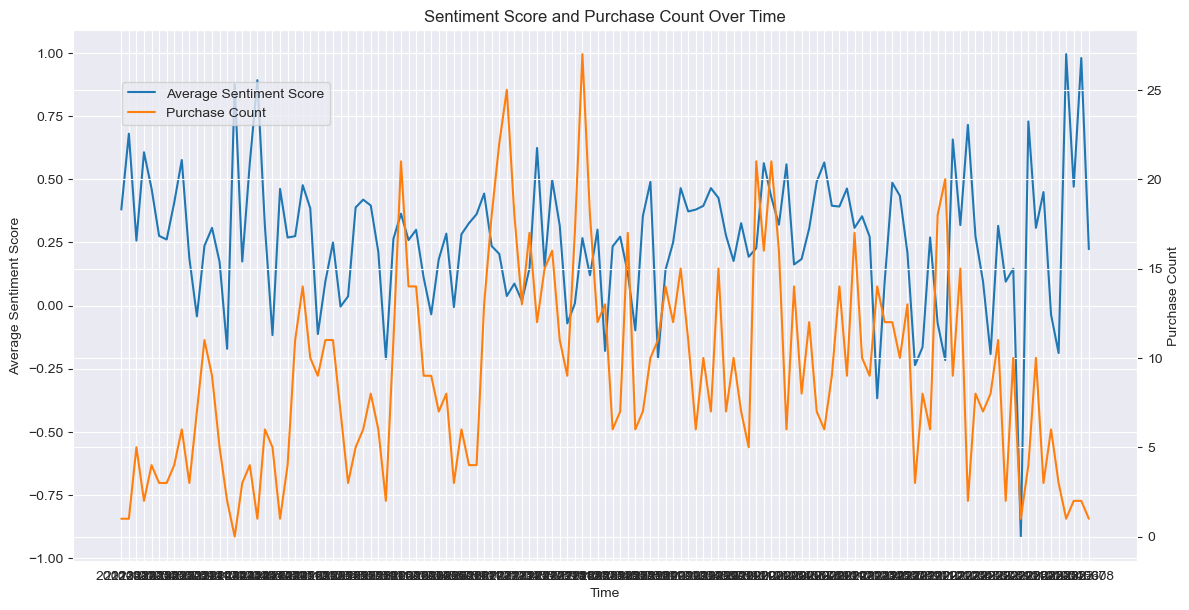

                     sentiment_score_avg  purchase_count
sentiment_score_avg             1.000000       -0.140007
purchase_count                 -0.140007        1.000000
                            OLS Regression Results                            
Dep. Variable:         purchase_count   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.539
Date:                Mon, 24 Jun 2024   Prob (F-statistic):              0.114
Time:                        19:06:07   Log-Likelihood:                -405.07
No. Observations:                 129   AIC:                             814.1
Df Residuals:                     127   BIC:                             819.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std e

In [3]:
# Visualization for OLS
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json

data = []

file_path = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

df = df[['year', 'month', 'day', 'sentiment_score', 'verified_purchase', 'parent_asin']]

parent_asin_filter = ''
df_filtered = df[df['parent_asin'] == parent_asin_filter].copy()

if df_filtered.empty:
    print(f"No data found for parent_asin: {parent_asin_filter}")
else:
    df_filtered['year_month'] = df_filtered['year'].astype(str) + '-' + df_filtered['month'].astype(str).str.zfill(2)

    # Aggregate sentiment scores and purchase counts by month
    df_summary = df_filtered.groupby('year_month').agg(
        sentiment_score_avg=('sentiment_score_roberta', 'mean'),
        purchase_count=('verified_purchase', 'sum')
    ).reset_index()

    print(df_summary.head())

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Sentiment Score')
    ax1.plot(df_summary['year_month'], df_summary['sentiment_score_avg'], label='Average Sentiment Score', color='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Purchase Count')
    ax2.plot(df_summary['year_month'], df_summary['purchase_count'], label='Purchase Count', color='tab:orange')

    fig.tight_layout()
    plt.title('Sentiment Score and Purchase Count Over Time')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.xticks(rotation=90)
    plt.show()

    correlation = df_summary[['sentiment_score_avg', 'purchase_count']].corr()
    print(correlation)

    X = df_summary['sentiment_score_avg']
    y = df_summary['purchase_count']

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())

In [ ]:
# PCA OLS
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

data = []

file_path = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# Select relevant columns and preprocess
df = df[['timestamp', 'sentiment_score', 'review_length', 'helpful_vote', 'verified_purchase', 'rating', 'has_images', 'weekday', 'average_rating', 'rating_number', 'parent_asin', 'year', 'month', 'day']]

# Filter the DataFrame for a specific parent_asin
parent_asin_filter = ''
df_filtered = df[df['parent_asin'] == parent_asin_filter].copy()

# Check if the filtered dataset is empty
if df_filtered.empty:
    print(f"No data found for parent_asin: {parent_asin_filter}")
else:
    # Convert categorical variables to integers
    df_filtered['verified_purchase'] = df_filtered['verified_purchase'].astype(int)
    df_filtered['has_images'] = df_filtered['has_images'].astype(int)

    # Aggregate data by month, calculating the count of reviews (purchase count) and the mean of other features
    df_monthly = df_filtered.groupby(['year', 'month']).agg({
        'parent_asin': 'count',  # Target variable, count of reviews as a proxy for purchase count
        'sentiment_score': 'mean',
        'review_length': 'mean',
        'helpful_vote': 'mean',
        'rating': 'mean',
        'has_images': 'mean',
        'weekday': 'mean',
        'average_rating': 'mean',
        'rating_number': 'mean'
    }).reset_index()

    # Rename the target variable
    df_monthly.rename(columns={'parent_asin': 'purchase_count'}, inplace=True)

    # Generate a new feature: the squared sentiment score
    df_monthly['sentiment_score_roberta_squared'] = df_monthly['sentiment_score'] ** 2

    # Select feature variables and target variable
    features = ['sentiment_score', 'sentiment_score_roberta_squared', 'review_length', 'helpful_vote', 'rating', 'has_images', 'weekday', 'average_rating', 'rating_number', 'year', 'month']
    target = 'purchase_count'

    X = df_monthly[features]
    y = df_monthly[target]

    # Ensure all feature variables are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    y = y.apply(pd.to_numeric, errors='coerce')

    # Handle NaN values
    X = X.fillna(0)
    y = y.fillna(0)

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_pca = pca.fit_transform(X_scaled)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Add a constant term (intercept)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Build a multiple linear regression model
    model = sm.OLS(y_train, X_train).fit()

    print(model.summary())

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

In [ ]:
# Partial Autocorrelation
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import json

data = []

file_path = ''
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

df = df[['timestamp', 'sentiment_score', 'parent_asin']]

parent_asin_filter = ''
df_filtered = df[df['parent_asin'] == parent_asin_filter]

# Check if the filtered dataset is empty
if df_filtered.empty:
    print(f"No data found for parent_asin: {parent_asin_filter}")
else:
    # Convert timestamp to datetime format
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], unit='ms')

    # Set timestamp as index
    df_filtered.set_index('timestamp', inplace=True)

    # Sort by time
    df_filtered.sort_index(inplace=True)

    plt.figure(figsize=(10, 6))
    plot_acf(df_filtered['sentiment_score'], lags=50)
    plt.title(f'Autocorrelation of Sentiment Scores for {parent_asin_filter}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

In [ ]:
# Try with ARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import json

data = []

file_path = '/Users/xinliguo/Downloads/filtered_reviews1100.jsonl'
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

df = df[['timestamp', 'sentiment_score', 'parent_asin']]

parent_asin_filter = ''
df_filtered = df[df['parent_asin'] == parent_asin_filter]

if df_filtered.empty:
    print(f"No data found for parent_asin: {parent_asin_filter}")
else:
    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], unit='ms')

    df_filtered.set_index('timestamp', inplace=True)

    df_filtered.sort_index(inplace=True)

    from statsmodels.tsa.arima.model import ARIMA

    # Fit ARIMA model
    model = ARIMA(df_filtered['sentiment_score'], order=(1, 1, 1))
    model_fit = model.fit()

    print(model_fit.summary())